## Import necessary libraries

In [1]:
import numpy as np
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt

# Task 1: Simple Image Operations

### 1. Load image

In [2]:
image = Image.open("Capybara.jpg")

### 2. Print width, height, and number of channels and plot the image

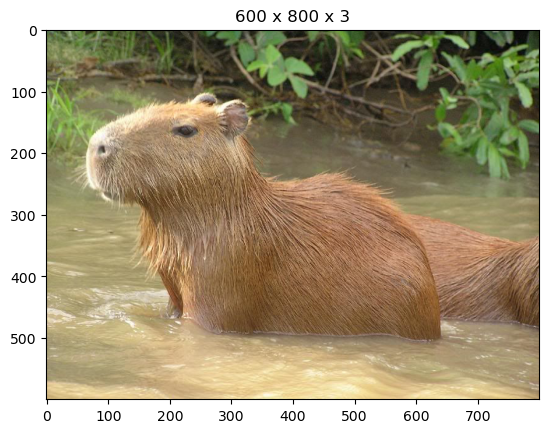

In [3]:
w, h = image.size
bands = image.getbands()

# Length of tuple R, G, B would be 3
c = len(bands)
title = "{} x {} x {}".format(h, w, c)
plt.imshow(image)
plt.title(title)
plt.show()

### 3. Crop a random patch of size 256x256 from the image

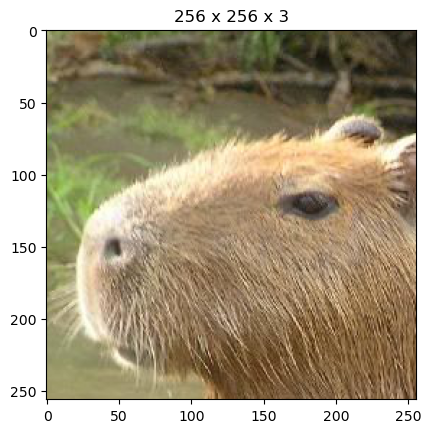

In [4]:
# left x1, upper y1, right x2, lower y2
cropped = image.crop((44,44,300,300))
w, h = cropped.size
# Get the bands/channels of the image, for example tuple "R", "G", "B" 
bands = cropped.getbands()
title = "{} x {} x {}".format(h, w, c)
plt.imshow(cropped)
plt.title(title)
plt.show()

### 4. Convert the image patch to grayscale

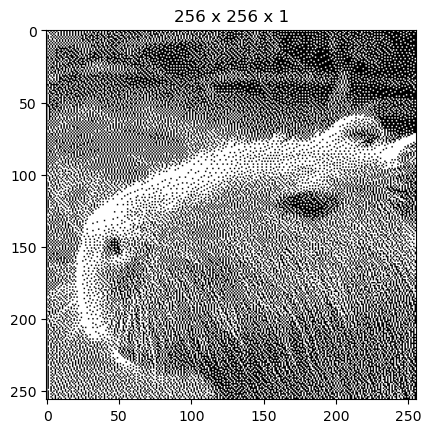

In [5]:
cropped_grayscale = cropped.convert('1')

w, h = cropped_grayscale.size
# Get the bands/channels of the image, for example tuple "R", "G", "B" 
bands = cropped_grayscale.getbands()
c = len(bands)
title = "{} x {} x {}".format(h, w, c)
plt.title(title)
plt.imshow(cropped_grayscale)
plt.show()

### 5. Insert the grayscale patch back into the original image

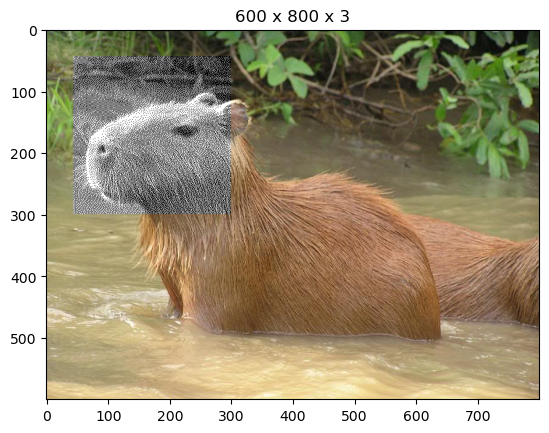

In [6]:
new_image = image.copy()
#new_image is the combination of original and cropped image
new_image.paste(cropped_grayscale,(44,44))

w, h = new_image.size
# Get the bands/channels of the image, for example tuple "R", "G", "B" 
bands = new_image.getbands()
c = len(bands)
title = "{} x {} x {}".format(h, w, c)

plt.imshow(new_image)
plt.title(title)
plt.show()

### 6. Resize the image with the inserted gray patch 

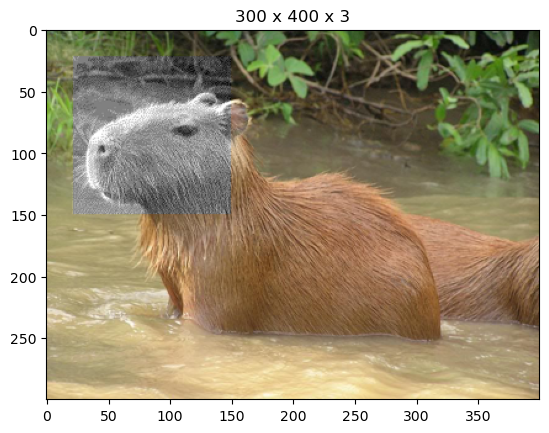

In [7]:
#scale down the new image height and width
new_width = int(new_image.width * 0.5)
new_height = int(new_image.height * 0.5)

resized_img = new_image.resize((new_width,new_height))
w, h = resized_img.size
# Get the bands/channels of the image, for example tuple "R", "G", "B" 
bands = resized_img.getbands()
c = len(bands)
title = "{} x {} x {}".format(h, w, c)

plt.imshow(resized_img)
plt.title(title)
plt.show()

# Task 2: Convolution and Filters

### Utils
take care of the range of the value before plot the images

In [8]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### 1. Implement convolution operation

In [9]:
def conv2d(x, kernel):
    """
    Performs a 2D convolution operation with a single kernel.

    Args:
        x      (array): the input array of shape (H, W, 1).
        kernel (array): the kernel that is convolved over the input.

    Returns:
        out    (array): the output array.
    """
    padding = 0; # default, not stated in exercise
    stride = 1; # default, not stated in exercise
    input_height = x.shape[0]
    input_width = x.shape[1]
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]
    #calculate output dimensions
    out_width = ((input_width - kernel_width + (2*padding)) // stride) + 1
    out_height = ((input_height - kernel_height + (2*padding)) // stride) + 1
    
    #create output numpy array
    conv_output = np.zeros((out_height,out_width))
    
    #iterate through height
    for i in range(out_height):
        start_height = i * stride
        end_height = start_height + kernel_height
        #iterate through width
        for j in range (out_width):
            start_width = j * stride
            end_width = start_width + kernel_width
            #sum the single multiplications of the numbers together and save it in the specific i,j location in the output array
            conv_output[i,j] = np.sum(x[start_height:end_height,start_width:end_width] * kernel)
    return conv_output


### 2. Implement a Gaussian filter

Gaussian filter:


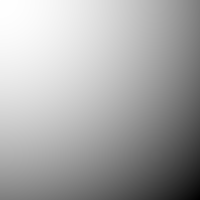

In [10]:
def gaussian_filter(size, mean=0, var=1):
    """
    Returns an isotropic Gaussian filter with.
    
    Args:
        size       (int): the size of the kernel.
        mean (float/int): the mean of the Gaussian.
        var  (float/int): the variance of the Gaussian.

    Returns:
        f        (array): the Gaussian filter of shape (size, size, 1).
    """
    kernel_output = np.zeros((size,size,1),np.float32)
    #iterate through each pixel
    for i in range (size):
        for j in range (size):
            #use formula given in the exercise sheet to calculate output
            first_term = 1 / (2.0 * np.pi * var)
            second_term = np.exp (- ((i**2.0 + j**2.0) / (2.0 * var**2.0)))
            kernel_output[i,j] = first_term * second_term       
    return kernel_output        

f = gaussian_filter(size=200, mean=0, var=1000)
print('Gaussian filter:')
display_img(f, norm=True)

### 3. Apply Gaussian filter to image

Original image:


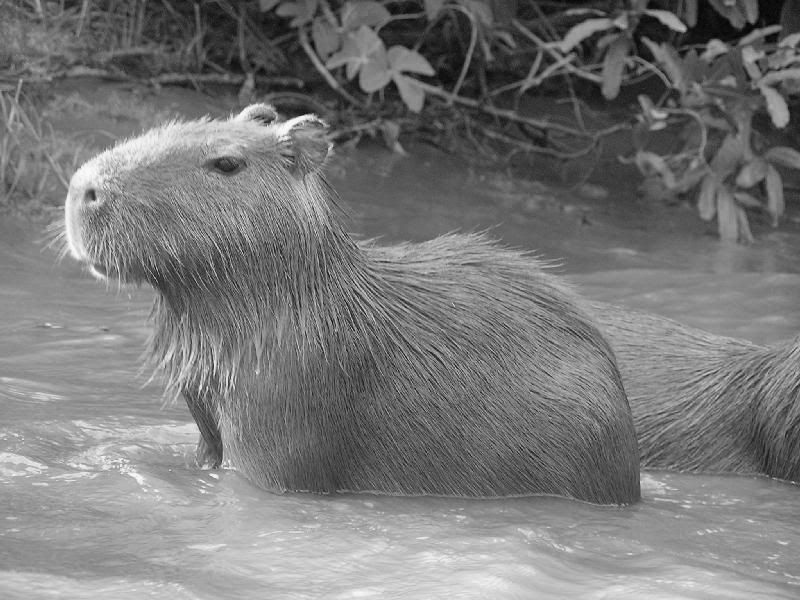

Gaussian filtered image:


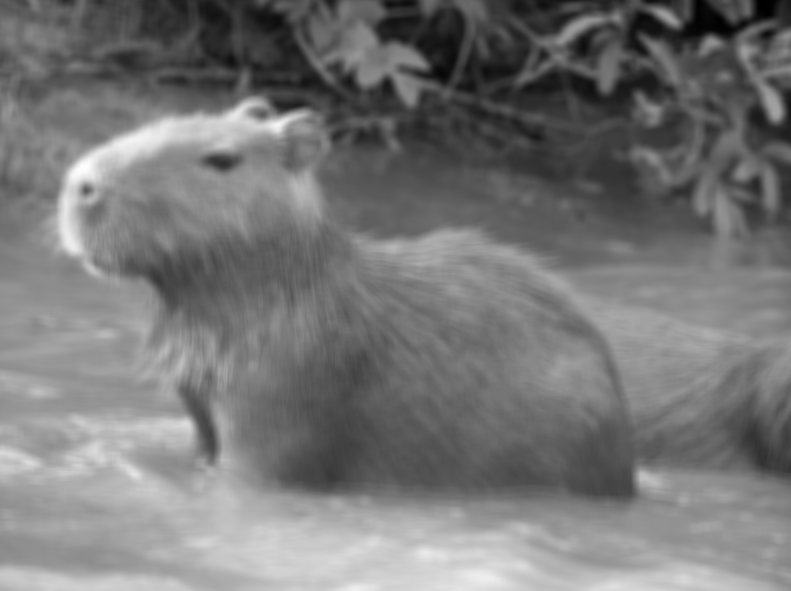

In [11]:
#first output
grayscale_img = load_img("Capybara.jpg",True)
array = np.asarray(grayscale_img)
#second output
gaus = gaussian_filter(10,10,255)
grayscale_img = grayscale_img / 255
array_filtered_gaussian = conv2d(grayscale_img,gaus)

print('Original image:')
display_img(array)
print('Gaussian filtered image:')
display_img(array_filtered_gaussian, norm=True)

### 4. Implement and apply Laplacian filter to image

Hint: If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see something

Original image:


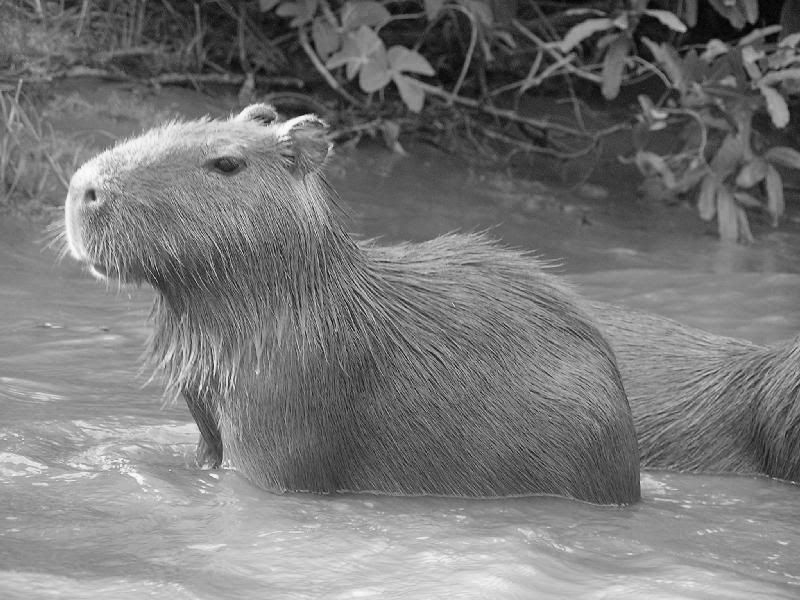

Laplacian filtered image:


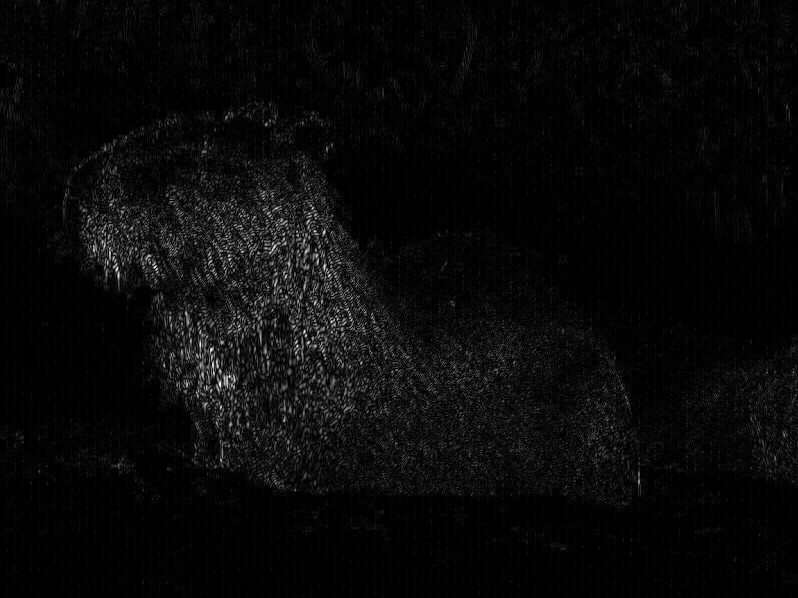

In [12]:
#ANSWER: Laplacian detector uses 2nd derivative of the pixels with respect to x and y (2D) to find the changes/zero crossings of pixels. 
#Crossing means when there is a jump  above a threshold in the values of the pixels
#When a zero crossing happens, that is signaling an edge.

#Definition of laplacian array according to wikipedia
laplace = np.array([[0, 1, 0],
                    [1, -4, 1],
                    [0, 1, 0]])

grayscale_img = load_img ("Capybara.jpg",True)
array = np.asarray(grayscale_img)

array_filtered = conv2d(grayscale_img,laplace)
# Make edges more visible
array_filtered = np.abs(array_filtered)

print('Original image:')
display_img(array, True)
print('Laplacian filtered image:')
display_img(array_filtered, True)

### 5. Problems with handcrafted filters

The problem with constructing the filters manually is that it takes time to find the right filters for our given dataset/images. It is a process of trial and error and it will be difficult to learn/capture/understand underlying patterns in different images of the dataset.
Deep Learning on the other hand comes in handy by using neural networks to learn the filter from the dataset efficiently. The algorithms of deep learning automate the manual work by doing it more quickly, efficiently and better/more accuracte.

# Task 3: Introduction to PyTorch

### 1. Convert NumPy array to PyTorch tensor and vice versa

In [13]:
image = Image.open('Capybara.jpg')
image_numpy_array = np.array(image)
print ('Initial H W C :')
print(image_numpy_array.shape)
tensor_image = torch.tensor(image_numpy_array)
tensor_image = tensor_image.permute(2,0,1)
print ('Switch to C H W :')
print(tensor_image.shape)
print ('Back to H W C :')
tensor_image = tensor_image.permute(1,2,0)
print(tensor_image.shape)
image_numpy_array = tensor_image.numpy()
#Saving back to numpy array and then to jpg
image_two = Image.fromarray(image_numpy_array, 'RGB')
image_two.save('Capybara_2.jpg')

Initial H W C :
(600, 800, 3)
Switch to C H W :
torch.Size([3, 600, 800])
Back to H W C :
torch.Size([600, 800, 3])


### 2. Create a PyTorch convolution operator

In [14]:
random_x = np.random.rand(*(5,5,1))
random_w = np.random.rand(*(2,2,1))
conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,bias=False)
x_tensor = torch.tensor(random_x)
w_tensor = torch.tensor(random_w)
#Change axis
x_tensor = x_tensor.permute(2,0,1)
w_tensor = w_tensor.permute(2,0,1)
#Add dimension
x_tensor = x_tensor.unsqueeze(dim=0)
w_tensor = w_tensor.unsqueeze(dim=0)

#Replace weights of conv
conv.weight = nn.Parameter(w_tensor)

#Pytorch convolution output
pytorch_output = conv(x_tensor)
print('Pytorch convolution output:')
print(pytorch_output)

#My own convolution output
print('Own convolution output:')
own_output = conv2d(random_x, random_w)
print(own_output)

Pytorch convolution output:
tensor([[[[1.0208, 1.1224, 0.8658, 0.9440],
          [0.7820, 0.7663, 1.0377, 0.8711],
          [1.1048, 1.0793, 0.7810, 0.4544],
          [1.3612, 0.8962, 0.4784, 1.1284]]]], dtype=torch.float64,
       grad_fn=<ConvolutionBackward0>)
Own convolution output:
[[1.02079879 1.12244929 0.86576418 0.94396904]
 [0.78196478 0.76629865 1.03774008 0.87112984]
 [1.10484107 1.07933663 0.78098515 0.45444238]
 [1.36119334 0.8962035  0.47839488 1.12836554]]


### 3. Apply Gaussian filter using nn.Conv2d

In [15]:
#helper functions

def tensor_to_numpy_array(input_tensor):
    output_array = input_tensor.detach().numpy()
    #remove first dimension of numpy array
    output_array = np.squeeze(output_array, axis=0)
    #swap axes to conform to numpy format H W C
    output_array=np.swapaxes(output_array,0,1)
    output_array=np.swapaxes(output_array,1,2)
    
    return output_array

def numpy_array_to_tensor(input_array):
    #convert numpy array to tensor
    output_tensor = torch.tensor(input_array)
    #change dimensions to conform to tensor format C H W
    output_tensor = output_tensor.permute(2,0,1)
    # add first dimension to tensor
    output_tensor = output_tensor.unsqueeze(dim=0)

    return output_tensor


Original image:


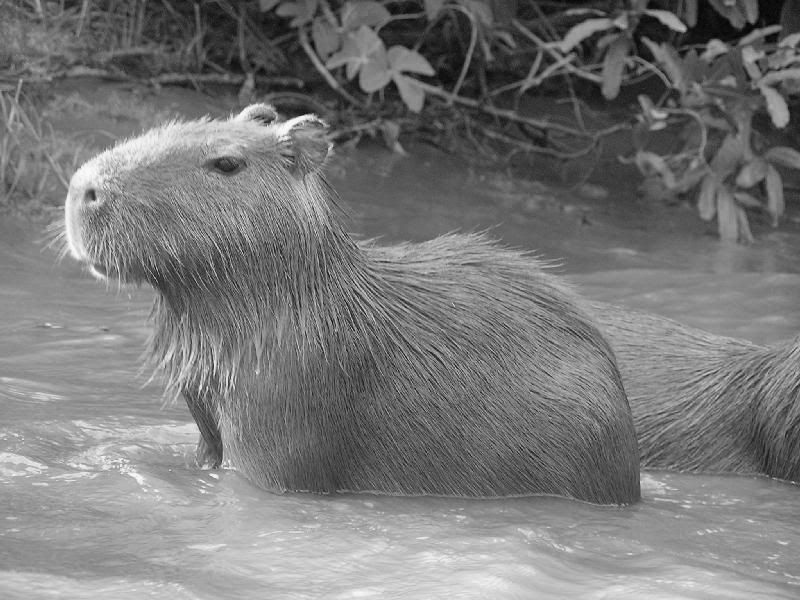

Filtered image:


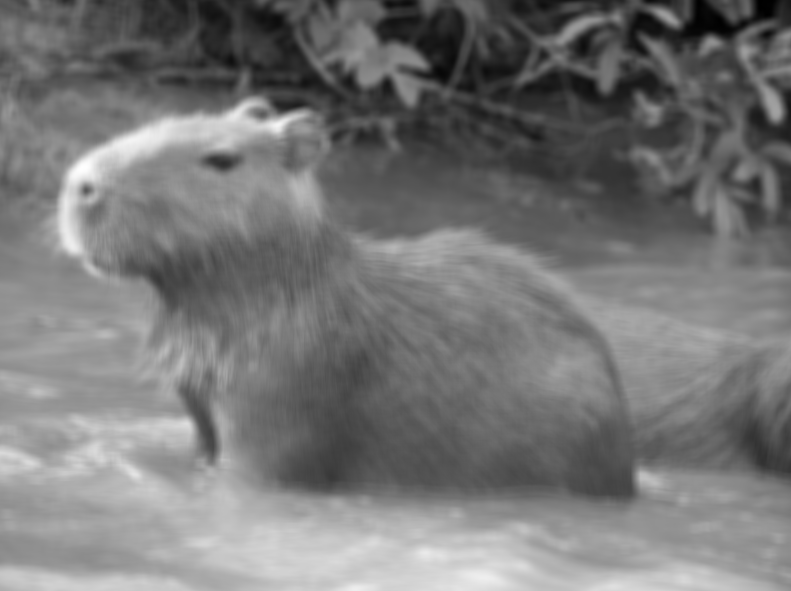

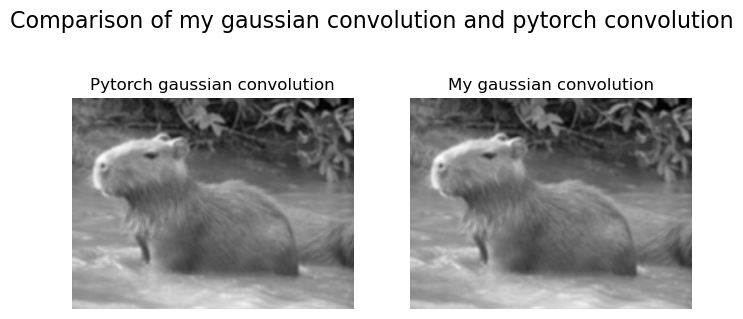

In [16]:
x = load_img ("Capybara.jpg",True)

#first image output
print('Original image:')
display_img(x)

#Define input and weights
gaus_array = gaussian_filter(10,10,255)
image_array = np.asarray(x)

#convert the numpy arrays to tensors for our convolution
gaus_tensor = numpy_array_to_tensor(gaus_array)
x_tensor = numpy_array_to_tensor(image_array)
#set weights for convolution
conv.weight = nn.Parameter(gaus_tensor)
#compute tensor
output_tensor = conv(x_tensor)
#convert the tensor back to numpy array
xx_filtered = tensor_to_numpy_array(output_tensor)

#second image output
print('Filtered image:')
display_img(xx_filtered, norm=True)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(xx_filtered, cmap='gray')
plt.title('Pytorch gaussian convolution')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(array_filtered_gaussian, cmap='gray') #array_filtered_gaussian comes from task 2
plt.title('My gaussian convolution')
plt.axis('off')

plt.suptitle('Comparison of my gaussian convolution and pytorch convolution', fontsize=16)
plt.show()